<a href="https://colab.research.google.com/github/cesar-claros/RL_tutorial/blob/main/RL_Q_learning(cart_reduced).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install required system dependencies
!apt-get install -y xvfb x11-utils > /dev/null
!pip install gym[box2d] pyvirtualdisplay  PyOpenGL PyOpenGL-accelerate > /dev/null

In [2]:
# Librerías
import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False,size=(1400, 900))  # use False with Xvfb                 
_ = _display.start()
!echo $DISPLAY

import gym
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import matplotlib.animation as animation
from tqdm import tqdm


:0


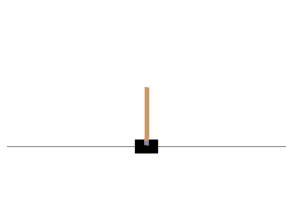

In [3]:
env = gym.make("CartPole-v1")

env.reset()
fig, ax = plt.subplots(figsize=(5, 5))
ax.axis('off')
img = ax.imshow(env.render(mode='rgb_array'))
display.display(plt.gcf())
display.clear_output(wait=True)
# Estados
# 0       Cart Position             -4.8                    4.8
# 1       Cart Velocity             -Inf                    Inf
# 2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
# 3       Pole Angular Velocity     -Inf                    Inf


In [5]:
# env = gym.make("MountainCar-v0")
env.reset()
fig, ax = plt.subplots(figsize=(5, 5))
ax.axis('off')
imgs = []
# done = False
N = 50
# Actions:
        # Type: Discrete(2)
        # Num   Action
        # 0     Push cart to the left
        # 1     Push cart to the right
for _ in range(N):
    action = np.random.randint(low=0,high=1)  # always go right!
    env.step(action)
    img = ax.imshow(env.render(mode='rgb_array'))
    imgs.append([img])
    # env.render()
ani = animation.ArtistAnimation(fig, imgs, interval=100, blit=True,
                                repeat_delay=1000)
plt.close()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
display.HTML(ani.to_html5_video())

In [12]:
# Discretizar espacio de estados continuo
def get_discrete_state(state, DISCRETE_OS_SIZE, max_limit, min_limit):
    # DISCRETE_OS_SIZE = [20, 20]
    discrete_os_win_size = (max_limit - min_limit)/DISCRETE_OS_SIZE
    discrete_state = (state - min_limit)/discrete_os_win_size
    return tuple(discrete_state.astype(np.int))  # we use this tuple to look up the 3 Q values for the available actions in the q-table

In [13]:
# Selecionar acción
def select_action(env, discrete_state, q_table, epsilon):
    if np.random.random() > epsilon:
        # Get action from Q table
        action = np.argmax(q_table[discrete_state])
    else:
        # Get random action
        action = np.random.randint(0, env.action_space.n)
    return action

In [14]:
# Actualizar tabla Q
def update_Q_table(q_table, new_discrete_state, action, LEARNING_RATE=0.1, DISCOUNT=0.95):
    # Maximum possible Q value in next step (for new state)
    max_future_q = np.max(q_table[new_discrete_state])

    # Current Q value (for current state and performed action)
    current_q = q_table[discrete_state + (action,)]

    # And here's our equation for a new Q value for current state and action
    new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)

    # Update Q table with new Q value
    q_table[discrete_state + (action,)] = new_q

    return q_table

In [33]:
# Objetivo: llegar a la bandera

# env = gym.make("MountainCar-v0")

env.reset()
LEARNING_RATE = 0.1
DISCOUNT = 0.95
EPISODES = 5000


# Exploration settings
epsilon = 1  # not a constant, going to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

# Number of discretized quantities for each state
DISCRETE_OS_SIZE = [20, 20]
q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))

# Boundary values for states
max_limit = env.observation_space.high
max_limit = np.array([max_limit[0], max_limit[2]])
min_limit = env.observation_space.low
min_limit = np.array([min_limit[0], min_limit[2]])

imgs = []
render = False
for episode in tqdm(range(EPISODES)):
    state = env.reset()
    state_reduced = [state[0], state[2]]
    discrete_state = get_discrete_state(state_reduced, DISCRETE_OS_SIZE, max_limit, min_limit)
    done = False

    while not done:
        # Tomar accion
        action = select_action(env, discrete_state, q_table, epsilon)
        # Obtener nuevo estado y recompensa
        new_state, reward, done, _ = env.step(action)
        # Discretizar estado
        new_state_reduced = [new_state[0], new_state[2]]
        new_discrete_state = get_discrete_state(new_state_reduced, DISCRETE_OS_SIZE, max_limit, min_limit)
        # Actualizar tabla Q
        q_table = update_Q_table(q_table, new_discrete_state, action)
        # Reasignar estado para siguiente iteración
        discrete_state = new_discrete_state

    # Estrategia para modificar la exploración-explotación iterativamente
    # Decaying is being done every episode if episode number is within decaying range
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value


env.close()

100%|██████████| 5000/5000 [00:08<00:00, 584.55it/s]


In [38]:
# env = gym.make("MountainCar-v0")
# Generar animación
env.reset()
fig, ax = plt.subplots(figsize=(5,5))
ax.axis('off')
imgs = []
# done = False
N = 1
T = 40
for episode in tqdm(range(N)):
    state = env.reset()
    state_reduced = [state[0], state[2]]
    discrete_state = get_discrete_state(state_reduced, DISCRETE_OS_SIZE, max_limit, min_limit)
    done = False

    # while not done:
    for _ in range(T):
        action = np.argmax(q_table[discrete_state])
        new_state, reward, done, _ = env.step(action)
        img = ax.imshow(env.render(mode='rgb_array'))
        imgs.append([img])
        new_state_reduced = [new_state[0], new_state[2]]
        new_discrete_state = get_discrete_state(new_state_reduced, DISCRETE_OS_SIZE, max_limit, min_limit)
        discrete_state = new_discrete_state
ani = animation.ArtistAnimation(fig, imgs, interval=100, blit=True,
                                repeat_delay=1000)
plt.close()
env.close()

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


In [39]:
display.HTML(ani.to_html5_video())